In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

PARENT_DIR = os.path.realpath('..')
import importlib
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [3]:
DIRS['RAW_DATA'] = '/data/dudyrev/Speach_Synthesizer/raw_data/'

In [4]:
quant = M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Build model

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

In [5]:
full_ds = pd.read_csv(DIRS['MANIFESTS']+'/total.csv',index_col=0)

/opt/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
full_ds['wav_exist'] = full_ds['wav'].apply(lambda f: os.path.isfile(f) if type(f)==str else False)
full_ds['txt_exist'] = full_ds['txt'].apply(lambda f: os.path.isfile(f) if type(f)==str else False)

In [7]:
to_train_ds = full_ds[(full_ds['wav_exist'])&(full_ds['txt_exist'])]

In [8]:
to_train_ds.shape, to_train_ds.shape[0]/full_ds.shape[0]

((1149404, 6), 0.16965730789594527)

In [9]:
to_train_ds.shape, to_train_ds.shape[0]/full_ds.shape[0]

((1149404, 6), 0.16965730789594527)

In [10]:
texts = []
n_files_to_load = int(to_train_ds.shape[0]*1)#0.1)
for idx, fname in tqdm_notebook(to_train_ds[:n_files_to_load]['txt'].iteritems(),total=n_files_to_load):
    with open(fname, 'rb') as f:
        t = f.read().decode().strip()
    texts.append(t)

HBox(children=(IntProgress(value=0, max=1149404), HTML(value='')))

In [11]:
txt_lens = [len(t) for t in texts]

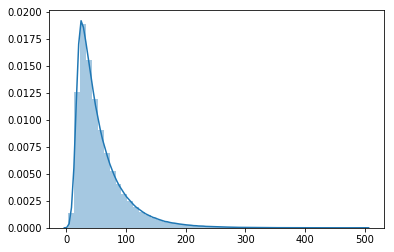

In [12]:
sns.distplot(txt_lens)

In [14]:
(np.array(txt_lens)<100).mean()

0.8750395857331278

In [13]:
(np.array(txt_lens)<80).mean()

0.797410658045387

# Develop models

## DocToVec

In [15]:
import gensim

In [16]:
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [17]:
texts_split = [t.split() for t in texts]

In [18]:
train_data = list(create_tagged_document(texts_split))
print(train_data[0])

TaggedDocument(['умрешь', 'от', 'голода'], [0])


## WaveGRU

In [80]:
import DWave4
DWave4 = importlib.reload(DWave4)

In [81]:
vars_to_restore = ['M_IrV','M_IuV','M_IeV', 'Ir','Iu','Ie',
 'Rr','Ru','Re','M_RrV','M_RuV','M_ReV',
 'O1','O2','O3','O4','M_O1V','M_O2V','M_O3V','M_O4V',
 'br','bu','be','bO1','bO2','bO3','bO4',
 ]
vars_to_restore = [x+':0' for x in vars_to_restore]

In [82]:
model_name = "final1_256"

In [83]:
#saver = tf.train.import_meta_graph(DIRS['MODELS']+model_name+'/final.meta')
#saver = tf.train.import_meta_graph(DIRS['MODELS']+model_name+'/checkpoint-4000.meta')
#saver.restore(sess,tf.train.latest_checkpoint(DIRS['MODELS']+model_name))
#restored_variables = {x.name:x.eval(session=sess) for x in tf.global_variables() if x.name in WaveGRU.vars_to_restore}
restored_variables=None
tf.reset_default_graph()
sess = tf.Session()
gru = DWave4.WaveGRU(3, 64, n_batches=1, restore_variables=restored_variables, hidden_size=256)
sess.run(tf.global_variables_initializer())

In [84]:
saver = tf.train.Saver()

In [85]:
from datetime import datetime

In [86]:
wav_fnames = list(to_train_ds['wav'])
text_fnames = list(to_train_ds['txt'])

In [88]:
save_period = 500

In [89]:
from datetime import datetime

In [90]:
log_fname = DIRS['NOTEBOOKS']+'logger'

In [91]:
start_epoch  = 0
gru_losses = []
start_learn = datetime.now()

In [92]:
len(texts)

1149404

In [93]:
t = texts[0]
t

'умрешь от голода'

In [95]:
n_epochs = min(len(wav_fnames), 250000)
#inferred_texts = [doc2vec.infer_vector(t.split()) for t in texts[:n_epochs]]
sparsity_epochs = np.arange(1000, n_epochs, 500)
#sparsity_epochs = (np.linspace(0.50, 0.95, 20)*n_epochs).astype(int)

In [96]:
len(sparsity_epochs)

498

In [102]:
(255-128)/128

0.9921875

In [104]:
max_val = (255-128)/128

In [110]:
%%time
audios = [sess.run(sl.load_data([wav_fnames[i]]))[0] for i in range(100)]

CPU times: user 31 s, sys: 0 ns, total: 31 s
Wall time: 30.9 s


In [113]:
audios = [np.concatenate([audio, [[max_val,max_val]]*(2*gru.n_batches-audio.shape[0]%gru.n_batches)]) for audio in audios]
audios = [np.concatenate([[[-1,-1]]*gru.n_batches,audio]) for audio in audios]
audios = [audio.reshape((gru.n_batches, -1, gru.input_dim-1)) for audio in audios]

In [ ]:
sparsity_lvl = 0.9
for epoch in tqdm_notebook(range(start_epoch, n_epochs)):
    #with open(text_fnames[epoch], 'rb') as f:
    #    t = f.read().decode().strip()
    #t = texts[epoch]
    #if len(t)>100:
    #    continue
    #txt_emb = txtConv.embed(t, sess)
    #txt_emb = doc2vec.infer_vector(t).reshape(1,-1)
    txt_emb = np.zeros((1,61))
    
    #audio = sess.run(sl.load_data([wav_fnames[epoch]]))[0]
    #audio = np.concatenate([audio, [[max_val,max_val]]*(2*gru.n_batches-audio.shape[0]%gru.n_batches)])
    #audio = np.concatenate([[[-1,-1]]*gru.n_batches,audio])
    #audio_resh = audio.reshape((gru.n_batches, -1, gru.input_dim-1))
    audio_resh = audios[epoch%len(audios)]
    
    if epoch in sparsity_epochs:
        k = gru.calc_sparsity_level(epoch, sparsity_epochs, sparsity_lvl)
        gru.sparsify(k, sess)
        print(f'sparsified by {k}')
    
    loss = gru.train(audio_resh, txt_emb, sess)
    gru_losses.append(loss)
    
    if epoch % 500==0:
        tm = datetime.now()
        with open(log_fname, 'a') as f:
            f.write(f'{model_name} {epoch} {loss:.5f} {(tm-start_learn).seconds} {((tm-start_learn).seconds)/(epoch-start_epoch) if epoch-start_epoch>0 else 0}\n')
        print(f'epoch {epoch} loss {loss}')

        print('time',tm, 'time from start',tm-start_learn, 'per_iteration', (tm-start_learn)/epoch if epoch!=0 else 0)
    
    if epoch % save_period == 0:
        saver.save(sess, DIRS['MODELS']+model_name+'/checkpoint',global_step=epoch,write_meta_graph=True)

HBox(children=(IntProgress(value=0, max=250000), HTML(value='')))

epoch 0 loss 4.65990686416626
time 2019-05-20 03:57:26.401429 time from start 0:09:12.465726 per_iteration 0


In [ ]:
plt.plot(gru_losses)

In [ ]:
saver.save(sess, DIRS['MODELS']+model_name+'/final_',write_meta_graph=True)

In [ ]:
gener_audio = gru.generate_audio(txt_emb, sess, seconds=1, show_tqdm=True)

In [ ]:
audio_real = audio*128+128
audio_real = audio_real[:,0]*256+audio_real[:,1]

In [ ]:
t

In [ ]:
plt.plot(audio_real)

In [ ]:
gener_audio

In [ ]:
plt.plot(gener_audio)

In [ ]:
h_t = np.zeros((gru.n_batches, gru.hidden_size), dtype='float32')
x = np.zeros((gru.n_batches, 1, gru.input_dim), dtype='float32')

In [ ]:
x = audio_resh[:,0].reshape(gru.n_batches, 1, gru.input_dim-1)

In [ ]:
c = x[:,:,0]
c_shift = np.hstack([c, [[0]]*gru.n_batches])[:,1:]
c_shift = c_shift.reshape(gru.n_batches,-1,1)
x = np.concatenate([x, c_shift],2)

In [ ]:
xs = [x[:,:,:2]]

In [ ]:
n_iters = 10

In [ ]:
feed_dict={gru.sound_X:x, gru.h_0:h_t, gru.txt_embed_plh:txt_emb}

In [ ]:
c_t = sess.run(gru.c_t, feed_dict=feed_dict)

In [ ]:
c_t

In [ ]:

#for i in tqdm_notebook(range(n_iters), disable=not show_tqdm):
    c_t = session.run(self.c_t, feed_dict=feed_dict)
    x[:,0,2] = c_t[:,0,0]
    feed_dict={self.sound_X:x, self.h_0:h_t, self.txt_embed_plh:txt_emb}
    x, h_t = session.run([self.y, self.h_t_trans], feed_dict=feed_dict) 
    x = np.concatenate([x,np.zeros((self.n_batches,1,1))],2)
    h_t = h_t[0] #[1,n_batches,hidden_size] -> [n_batches, hidden_size]
    xs.append(x[:,:,:2])